### Neshyba 2023


# Particle-on-a-bumpy-line

## Introduction

### Why talk about a varying potential energy surface?

We've argued previously that the particle-in-a-line model does a good job of simulating the $\pi$-system of simple conjugated polyenes like $C_{10}H_{12}$, because $\pi$ electrons in such molecules don't "feel" changes in potential energy as they move past one carbon atom to another. But what about molecules in which there are atoms that electrons are likely to be much more attracted to? For example, consider $C_9H_{10}O$, which has an oxygen at the end instead of a carbon.

<p style='text-align: center;'>
<img src="http://webspace.pugetsound.edu/facultypages/nesh/Notebook/C9H10O.png" height="700" width="700"/>  
<strong>Figure 1</strong>. Structure of the conjugated aldehyde $C_9H_{10}O$, according to Spartan<sup>TM</sup>.
    
Because oxygen is notoriously *electronegative*, we would expect it to attract $\pi$ electrons much more than carbon atoms would. Mathematically, we'd say the potential energy between an oxygen atom and a $\pi$ electron to be  *lower* than the potential energy between a carbon atom and a $\pi$ electron. An example, generated in Python, is shown in Fig. 2.

<p style='text-align: center;'>
<img src="http://webspace.pugetsound.edu/facultypages/nesh/Notebook/Step potential.png" height="700" width="700"/> 
<strong>Figure 2</strong>. Potential energy surface with a step, generated in Python with PL.step_potential.

Can we use this function to solve for the quantum mechanical properties using methods discussed previously? We can't use our analytical result, $E_n = {n^2 h^2 \over 8ma^2}$, because that was derived assuming a flat potential energy surface. But we can use matrix diagonalization method -- we just need to build a matrix representation of the Hamiltonian operator $H=-{\hbar^2 \over 2m} \nabla^2+V$, using $V$ as shown in Fig. 2. You've already done something similar, when you experimented with raising and lowering the reference value of a flat potential.

### Tunneling
A new feature that can come up in these circumstances is what's called *tunneling*. That happens when we see that the particle appears to be burrowing into a space where the potential energy is higher than the total energy of the electron! Impossible? Not according to quantum mechanics.


### The idea of this exercise
To summarize, you have a way to solve the quantum mechanical problem of a particle-on-a-line, even when the potential energy surface is bumpy like the one shown in Fig. 2. And when you've finished solving the particle-on-a-line problem, you can carry out similar analyses, such as inferring how fast the electron is moving from the apparent de Broglie wavelenth ($v = {h \over m \lambda_{de Broglie}}$), as well as the possibility of tunneling. Hopefully, the result of all this thinking will add up to a better intuition about the quantum mechanics of delocalized electrons, and the methodologies used to make predictions.

### Learning goals
The main learning goals of this exercise are 
1. I can modify the *Particle-on-a-line* model in order to simulate situations that call for a structured (i.e., non-flat) potential energy surface.
1. I can recognize relationships between solutions of the particle-on-a-line and more precise electronic structure calculations. 
1. I can recognize when tunneling is happening.

In [1]:
import pint; from pint import UnitRegistry; AssignQuantity = UnitRegistry(system='atomic').Quantity
import numpy as np
import scipy.linalg as spla
import matplotlib.pyplot as plt
import PchemLibrary as PL
import plotly.graph_objects as go
%matplotlib notebook

In [2]:
# Quantum constants
hbar = AssignQuantity(1,'atomic_unit_of_time * hartree')
h = hbar*2*np.pi
m = AssignQuantity(1,'atomic_unit_of_mass')

### Getting distances from Spartan
As before, we'll need some information from Spartan to complete this exercise. In particular, you'll need the distance of the "line" (i.e., the length of the conjugated aldehyde $C_9H_{10}O$). Taking a lesson from previous work, you should probably augment this value by a few percent, when you actually employ it below.

You'll also, eventually, need to familiarize yourself with the $\pi$-system orbitals of this molecule, appearing in Spartan.

### Generating a stepped potential energy function

The function we're using is in PchemLibary.py. You can get help on how to use it with the command

    help(PL.step_potential)

Try it out! Then try actually using it, for example, by saying

    V = PL.step_potential(xvec, 10, 0, -1.5, True)

With the "True" flag turned on, the code will generate a graph of the potential. It should have a step at 10 bohr, where it drops precipitously from zero to -1.5 hartree.

11.3672 angstrom
21.480894803806375 bohr
Help on function step_potential in module PchemLibrary:

step_potential(xvec, xbump, Vleft, Vright, graphit=False)
    Creates a surface that jumps from Vleft to Vright, at position xbump
    The surface is returned in the form of a diagonal matrix whose dimensions match xvec



<IPython.core.display.Javascript object>


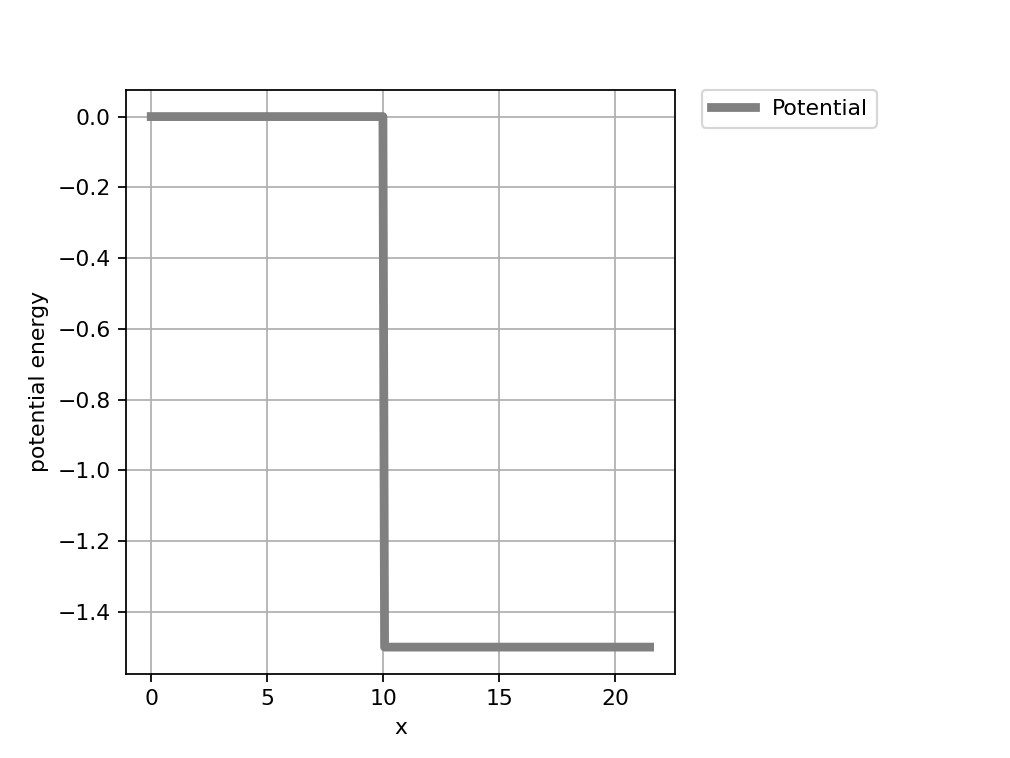

/home/instructor/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


In [3]:
# Specify the length of the molecule (i.e., your Spartan result, extended a bit). Use variable "a" for this.
### BEGIN SOLUTION
a = 10.93*1.04
a = AssignQuantity(a,'angstrom'); print(a)
a.ito('bohr'); print(a)
### END SOLUTION

# Get help on PL.step_potential
### BEGIN SOLUTION
help(PL.step_potential)
### END SOLUTION

# Create a grid of points across the line (xvec) and calculate the grid spacing (dx) while we're at it 
### BEGIN SOLUTION
nsteps = 300
xvec=np.linspace(0,a,nsteps)
dx = xvec[1]-xvec[0]
### END SOLUTION

# Create the step potential function (V)
### BEGIN SOLUTION
V = PL.step_potential(xvec, 10, 0, -1.5, True)
### END SOLUTION

### Solving the particle-on-a-line model  by diagonalizing the Hamiltonian matrix
Use the cell below to calculate the energies and wave functions for the particle-on-a-line model by constructing a matrix representation the Hamiltonian operator. You should plan on running this cell, comparing results to Spartan-generated wave functions, and modifying the parameters for the "bump" (the call to PL.step_potential) until you get a reasonable match. For example, the default here

    V = PL.step_potential(xvec, 7, 0, -1.5, False)

puts the transition to the low-potential-energy part of the molecule way too far to the left -- it should be closer to 15 or 20 bohr! Also, that drop in potential energy, to -1.5 hartrees, is probably too big.

/home/instructor/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:601: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  a = asarray(a, dtype=dtype, order=order)


<IPython.core.display.Javascript object>


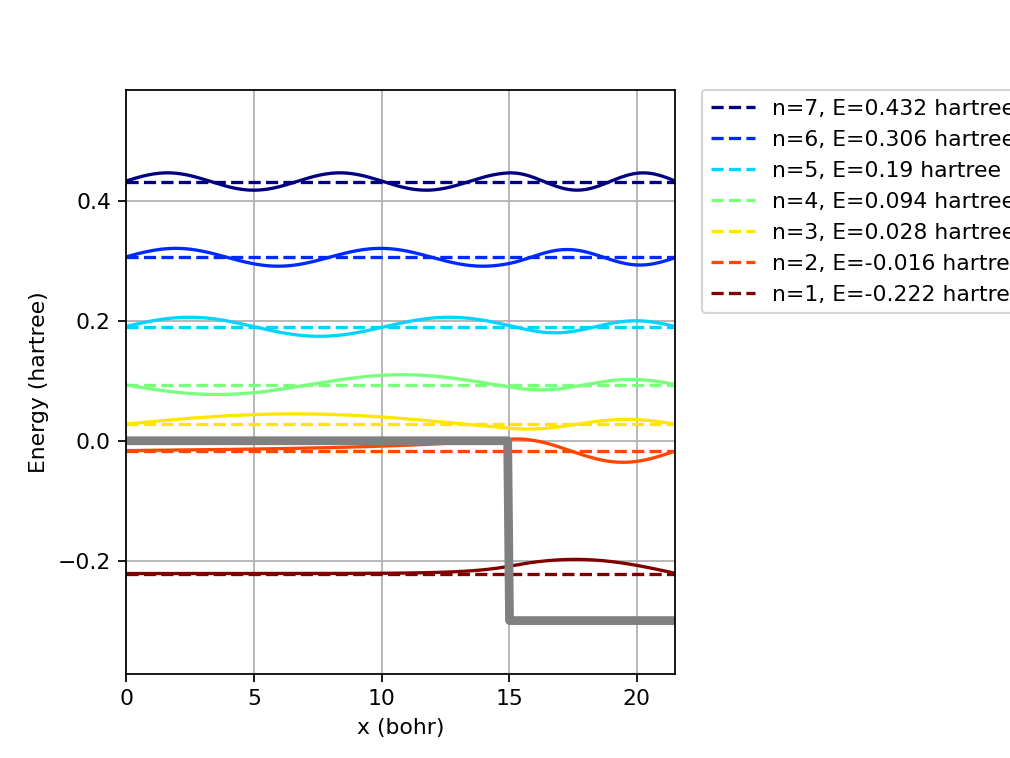

In [4]:
# Create a Laplacian matrix using the 3-point finite-difference method
Laplacian=(-2.0*np.diag(np.ones(nsteps))+np.diag(np.ones(nsteps-1),1)+np.diag(np.ones(nsteps-1),-1))/dx**2

# Create a stepped potential energy. Set the flag to False if you don't want to see the graphical depiction.
### BEGIN SOLUTION
V = PL.step_potential(xvec, 10, 0, -1.5, False)
V = PL.step_potential(xvec, 15, 0, -.3, False)
V = AssignQuantity(V,'hartree')
### END SOLUTION

# Create the Hamiltonian
### BEGIN SOLUTION
Hamiltonian = -0.5*hbar**2/m*Laplacian + V
Hamiltonian.ito('hartree')
### END SOLUTION

# Diagonalize the Hamiltonian yielding the wavefunctions and energies
### BEGIN SOLUTION
Epsi,psi = spla.eigh(Hamiltonian)
Epsi = AssignQuantity(Epsi,'hartree')
### END SOLUTION

# Specify the number of wavefunctions we want to look at
### BEGIN SOLUTION
number_of_wavefunctions = 7
### END SOLUTION

# Plot the wavefunctions
### BEGIN SOLUTION
PL.plotter(Epsi,psi,xvec,V,number_of_wavefunctions)
### END SOLUTION

### Pause for analysis

1. How many wavefunctions are "caught" in the pit on the right? Is that consistent with what Spartan is saying?
1. Which wavefunction(s) appear to be tunneling? Where and how?

### BEGIN SOLUTION


### END SOLUTION

### Refreshing and saving your code
1. Use the dropdown menu Kernel/Restart
2. Use the dropdown menu Cell/Run All Above
3. Under the "File" dropdown menu item in the upper left is a disk icon. Press it now to save your work (you can, do this at any time as you're working on an assignment, actually).

### Validating
This step will help ensure that you didn't miss something (although it's not a guarantee). Find the "Validate" button and press it. If there are any errors or warnings, fix them.

### Finishing up
Assuming all this has gone smoothly, carry out three more steps (but read this carefully before starting):
1. Close this notebook using the "File/Close and Halt" dropdown menu
1. Using the Assignments tab, submit this notebook
1. Press the Logout tab of the Home Page